PERSISTENCE EITHER ON TOTAL DATA AND ON FIRST 30 DAYS, TEST RESPECTIVELY ON LAST 44 AND LAST 10 OBSERVATIONS

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

In [ ]:
from pandas import read_csv
from pandas import read_excel
from matplotlib import pyplot

from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

In [ ]:
# load the dataset
ita_complete = ita_complete = read_csv("/content/drive/My Drive/Colab Notebooks/dpc-covid19-ita-andamento-nazionale.csv")
data=ita_complete[["date","totale_positivi","deceduti"]]
data.rename(columns={'totale_positivi':'total_pos', 'deceduti':'deaths'}, inplace=True)
series=data.total_pos

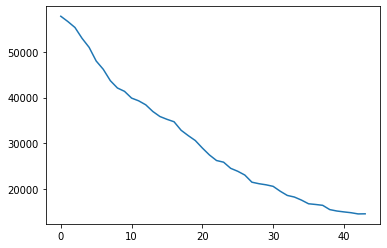

In [ ]:
pyplot.plot(series[-44:])

In [ ]:
# grid search simple forecast (persistence, mean, median)
# (test su ultimi 44)

# one-step simple forecast
def simple_forecast(history, config):
  n, offset, avg_type = config
  # persist value, ignore other config
  if avg_type == 'persist':
    return history[-n]
  # collect values to average
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
      raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
      ix = i * offset
      values.append(history[-ix])
  # check if we can average
  if len(values) < 2:
    raise Exception('Cannot calculate average')
  # mean of last n values
  if avg_type == 'mean':
    return mean(values)
  # median of last n values
  return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = simple_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # estimate prediction error
  error = measure_rmse(test, predictions)
  return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
# never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
      # execute configs in parallel
      executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
      tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
      scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1,2,3,4,5,6, 7]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

if __name__ == '__main__':
  # define dataset
  series = data.total_pos.values
  # data split
  n_test = 44
  # model configs
  max_length = len(series) - n_test
  cfg_list = simple_configs(max_length)
  # grid search
  scores = grid_search(series, cfg_list, n_test)
  print('done')
  # list top 3 configs
  for cfg, error in scores[:10]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 1225.509
 > Model[[1, 2, 'persist']] 1225.509
 > Model[[1, 3, 'persist']] 1225.509
 > Model[[1, 4, 'persist']] 1225.509
 > Model[[1, 5, 'persist']] 1225.509
 > Model[[1, 7, 'persist']] 1225.509
 > Model[[1, 6, 'persist']] 1225.509
 > Model[[2, 1, 'persist']] 2394.909
 > Model[[2, 2, 'persist']] 2394.909
 > Model[[2, 1, 'mean']] 1796.670
 > Model[[2, 2, 'mean']] 3594.857
 > Model[[2, 1, 'median']] 1796.670
 > Model[[2, 3, 'mean']] 5445.962
 > Model[[2, 3, 'median']] 5445.962
 > Model[[2, 2, 'median']] 3594.857
 > Model[[2, 3, 'persist']] 2394.909
 > Model[[2, 6, 'persist']] 2394.909
 > Model[[2, 6, 'mean']] 11588.621
 > Model[[2, 6, 'median']] 11588.621
 > Model[[2, 4, 'persist']] 2394.909
 > Model[[2, 4, 'mean']] 7368.520
 > Model[[2, 7, 'persist']] 2394.909
 > Model[[2, 4, 'median']] 7368.520
 > Model[[2, 7, 'mean']] 13748.196
 > Model[[2, 5, 'persist']] 2394.909
 > Model[[2, 5, 'mean']] 9438.094
 > Model[[2, 7, 'median']] 13748.196
 > Model[[3, 1, 'persist

In [ ]:
# persistence su primi 30 giorni - test ultimi 10

In [ ]:
# grid search simple forecast (persistence, mean, median)
# (test su ultimi 10)

# one-step simple forecast
def simple_forecast(history, config):
  n, offset, avg_type = config
  # persist value, ignore other config
  if avg_type == 'persist':
    return history[-n]
  # collect values to average
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
      raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
      ix = i * offset
      values.append(history[-ix])
  # check if we can average
  if len(values) < 2:
    raise Exception('Cannot calculate average')
  # mean of last n values
  if avg_type == 'mean':
    return mean(values)
  # median of last n values
  return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = simple_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # estimate prediction error
  error = measure_rmse(test, predictions)
  return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
# never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
      # execute configs in parallel
      executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
      tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
      scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1,2,3,4,5,6, 7]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

if __name__ == '__main__':
  # define dataset
  series = data.total_pos[:30].values
  # data split
  n_test = 10
  # model configs
  max_length = len(series) - n_test
  cfg_list = simple_configs(max_length)
  # grid search
  scores = grid_search(series, cfg_list, n_test)
  print('done')
  # list top 3 configs
  for cfg, error in scores[:10]:
    print(cfg, error)

 > Model[[1, 2, 'persist']] 3718.880
 > Model[[1, 1, 'persist']] 3718.880
 > Model[[1, 4, 'persist']] 3718.880
 > Model[[1, 5, 'persist']] 3718.880
 > Model[[1, 3, 'persist']] 3718.880
 > Model[[1, 6, 'persist']] 3718.880
 > Model[[2, 1, 'persist']] 7334.690
 > Model[[1, 7, 'persist']] 3718.880
 > Model[[2, 1, 'mean']] 5521.523
 > Model[[2, 2, 'persist']] 7334.690
 > Model[[2, 2, 'mean']] 10691.355
 > Model[[2, 1, 'median']] 5521.523
 > Model[[2, 2, 'median']] 10691.355
 > Model[[2, 3, 'mean']] 15222.519
 > Model[[2, 3, 'persist']] 7334.690
 > Model[[2, 3, 'median']] 15222.519
 > Model[[2, 6, 'persist']] 7334.690
 > Model[[2, 4, 'persist']] 7334.690
 > Model[[2, 4, 'mean']] 19114.892
 > Model[[2, 4, 'median']] 19114.892
 > Model[[2, 6, 'mean']] 25336.019
 > Model[[2, 5, 'persist']] 7334.690
 > Model[[2, 6, 'median']] 25336.019
 > Model[[2, 5, 'mean']] 22540.308
 > Model[[2, 7, 'persist']] 7334.690
 > Model[[2, 7, 'mean']] 27573.905
 > Model[[2, 5, 'median']] 22540.308
 > Model[[2, 7, '

In [ ]:
# analisi ripetuta su dati owid (test su ultimi 80)

In [ ]:
ita_owid=read_excel("/content/drive/My Drive/Colab Notebooks/ita_owid.xlsx", index_col=0)

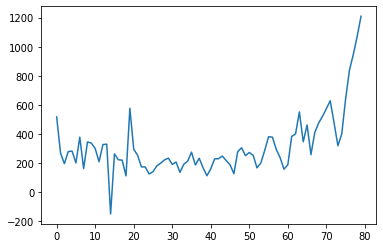

In [ ]:
series2=ita_owid.cases.values
pyplot.plot(series2[-80:])

In [ ]:
# grid search simple forecast (persistence, mean, median)

if __name__ == '__main__':
  # define dataset
  series2 = ita_owid.cases.values
  # data split
  n_test = 80
  # model configs
  max_length = len(series2) - n_test
  cfg_list = simple_configs(max_length)
  # grid search
  scores = grid_search(series2, cfg_list, n_test)
  print('done')
  # list top 3 configs
  for cfg, error in scores[:10]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 139.494
 > Model[[1, 2, 'persist']] 139.494
 > Model[[1, 3, 'persist']] 139.494
 > Model[[1, 4, 'persist']] 139.494
 > Model[[1, 5, 'persist']] 139.494
 > Model[[1, 7, 'persist']] 139.494
 > Model[[1, 6, 'persist']] 139.494
 > Model[[2, 2, 'persist']] 157.838
 > Model[[2, 1, 'persist']] 157.838
 > Model[[2, 1, 'mean']] 131.589
 > Model[[2, 2, 'mean']] 158.838
 > Model[[2, 2, 'median']] 158.838
 > Model[[2, 1, 'median']] 131.589
 > Model[[2, 3, 'persist']] 157.838
 > Model[[2, 3, 'mean']] 162.992
 > Model[[2, 6, 'persist']] 157.838
 > Model[[2, 3, 'median']] 162.992
 > Model[[2, 6, 'mean']] 188.726
 > Model[[2, 4, 'persist']] 157.838
 > Model[[2, 6, 'median']] 188.726
 > Model[[2, 4, 'mean']] 166.948
 > Model[[2, 7, 'persist']] 157.838
 > Model[[2, 7, 'mean']] 181.621
 > Model[[2, 4, 'median']] 166.948
 > Model[[2, 5, 'persist']] 157.838
 > Model[[2, 7, 'median']] 181.621
 > Model[[2, 5, 'mean']] 191.989
 > Model[[2, 5, 'median']] 191.989
 > Model[[3, 1, 'per